# Comparison of forecast algorithms for time series data

This notebook's goal is to compare the different forecast algorithms implemented (found in the different directories). For this we will compare them using 3 different indicators:

### Training time

It is the time (in seconds) the algorithm takes to analyse the data and for the neural networks to modify the weights of the neurons.

### Inference time

It is the time the algorithm takes to predict the $X$ next data of the time series.

### Accuracy

To determine the accuracy of the différent prediction of our algorithm we will use the **Root Mean Square** method.  
To calculate this indicator we need the data predected ($x_1$) and the real data ($x_2$), and we just have to use the following formula :
<p align="center">
    <img width="200" height="100" src="rms.svg">
</p>


## 1) Insertions and definitions

In this part we will insert all the library we will use in this jupyter notebook. We will also define all the usefull functions to alyse our data.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_dataset(dnn):
    # AutoRegressive Integrated Mooving Averge
    arima_id = pd.read_csv('ARIMA/ARIMA_id.csv')
    arima_diff = pd.read_csv('ARIMA/ARIMA_id2_diff.csv')
    # Long Short-Term Memory
    lstm_id = pd.read_csv('LSTM/LSTM_id2.csv')
    lstm_name = pd.read_csv('LSTM/LSTM_name2.csv')
    # Gated Recurrent Uniteddatadiff
    gru_id = pd.read_csv('GRU/GRU_id2.csv')
    gru_name = pd.read_csv('GRU/GRU_name2.csv')
    # Recurrent Neural Network
    rnn_id = pd.read_csv('RNN/RNN_id.csv')
    rnn_name = pd.read_csv('RNN/RNN_name.csv')
    # Deep Neural Network with lookback=10 and units=16,8
    dnn_168_id = pd.read_csv('DNN/DNN_16_id.csv')
    # Deep Neural Network with lookback=10 and 1st units=16,16
    dnn_1616_id = pd.read_csv('DNN/DNN_1616_id.csv')
    # Deep Neural Network with lookback=10
    dnn_id = pd.read_csv('DNN/DNN_id.csv')
    dnn_name = pd.read_csv('DNN/DNN_name.csv')
    # Deep Neural Network with lookback=30
    dnn_30_id = pd.read_csv('DNN/DNN_30_id2.csv')
    dnn_30_name = pd.read_csv('DNN/DNN_30_name2.csv')
    
    # List of dataset
    if not dnn:
        dataset = [arima_id, arima_diff, lstm_id, lstm_name, gru_id, gru_name, dnn_id, dnn_name, rnn_id, rnn_name]  # , dnn_30_id, dnn_30_name, dnn_168_id, dnn_1616_id]
        dataname = ['arima_id', 'arima_diff', 'lstm_id', 'lstm_name', 'gru_id', 'gru_name', 'dnn_id', 'dnn_name', 'rnn_id', 'rnn_name']  # , 'dnn_30_id', 'dnn_30_name', 'dnn_168_id', 'dnn_1616_id']
    else:
        dataset = [dnn_id, dnn_name, dnn_30_id, dnn_30_name, dnn_168_id, dnn_1616_id]
        dataname = ['dnn_id', 'dnn_name', 'dnn_30_id', 'dnn_30_name', 'dnn_168_id', 'dnn_1616_id']
    
    return dataset, dataname

def synthesis(dataset, dataname, string, decim, prin):
    order = False
    if string == 'order_time':
        if prin:
            print('Training time and time of order computing for arima comparaison (seconds) :')
        string = 'training_time'
        order = True
    if (not order) and prin:
        print('{} comparaison '.format(re.sub('_', ' ', string).capitalize()),end='')
        if string[-5:] == '_time':
            print('(seconds) ',end='')
        print(':')
    l = []
    for j in range(len(dataset)):
        cptr = 0
        if string == 'training_time' and dataname[j][-5:] == '_name':
            tmp = []
            for i in range(0, dataset[j].shape[0]):
                if dataset[0].loc[i,'metric_name'] not in tmp:
                    tmp.append(dataset[0].loc[i,'metric_name'])
                    cptr += dataset[j].loc[i,string]
        else:
            for i in range(0, dataset[j].shape[0]):
                if order and  dataname[j][:5] == 'arima':
                    cptr += dataset[j].loc[i,string] + dataset[0].loc[i,'order_time']
                else:
                    cptr += dataset[j].loc[i,string]
        l.append([dataname[j], cptr/dataset[j].shape[0]])
    l = sorted(l, key=lambda cptr: cptr[1])
    if prin:
        l1, l2 = l[:int(len(l)/2)], l[int(len(l)/2):]
        space = '      '
        for tup1, tup2 in zip(l1, l2):
            print('{name:11} : {val:11} {spac} | {spac} {name2:11} : {val2:11}'.format(name=tup1[0], val=round(tup1[1], decim), spac=space, name2=tup2[0], val2=round(tup2[1], decim)))
    return l

def adjust(liste):
    m = liste[-1][1]
    res = []
    for i in range(len(liste)):
        res.append([liste[i][0], (liste[i][1]/m)*100])
    return res
        
def autolabel(ax, rects, liste, n):
    i = 0
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 5+h, '{}'.format(round(liste[i][1], n)),
                ha='center', va='bottom', rotation=90)
        i+=1

# Comparaison id/name temps d'entrainement/RMS
def comp_idName(algo, order_training, mean_squared):
    for liste in order_training:
        if algo.lower() + '_name' == liste[0]:
            order_name = liste[1]
        if algo.lower() + '_id' == liste[0]:
            order_id = liste[1]
    for liste in mean_squared:
        if algo.lower() + '_name' == liste[0]:
            mean_name = liste[1]
        if algo.lower() + '_id' == liste[0]:
            mean_id = liste[1]
    print('\tMean of training time of the {} algorithm :'.format(algo))
    print("{first:55} : {second:5} seconds/metric_id".format(first='Training on each mectric_id', second=round(order_id,2)))
    print("{first:55} : {second:5} seconds/metric_id".format(first='Training on a single metric_id for an entire metri_name', second=round(order_name,2)))
    print('\n\tMean of root mean squared error of the {} algorithm :'.format(algo))
    print("{first:55} : {second:5}".format(first='Training on each mectric_id', second=round(mean_id,2)))
    print("{first:55} : {second:5}".format(first='Training on a single metric_id for an entire metri_name', second=round(mean_name,2)))

    print('\nTraining only on a single metric_id for an entire metri_name is {} time faster,\nbut we are loosing {}% of precision'.format(round(order_id/order_name,2), round(100*mean_name/mean_id,2)))
    
def moustaches(dataset, dataname, string):
    k=0
    fig1, ax1 = plt.subplots(int(len(dataset)/2),2,figsize=(20,12))
    for i in range(len(dataset)):
        ax1[k,(i%2)].set_title('Horizontal Boxes of {}'.format(dataname[i]))
        ax1[k,(i%2)].boxplot(dataset[i][[string]], vert=False)
        if i%2==1:
            k+=1
    fig1.tight_layout()
    plt.show()

def val_extr(data, string):
    aber = []
    for algo in data:
        Q1 = np.quantile(algo[string], 0.25)
        Q3 = np.quantile(algo[string], 0.75)
        EIQ = Q3 - Q1
        lim_inf = Q1 - 1.5*EIQ
        lim_sup = Q3 + 1.5*EIQ
        indx = list(algo[string].index[(algo[string] < lim_inf) | (lim_sup < algo[string])])
        for x in indx:
            if x not in aber:
                aber.append(x)
    for algo in data:
        algo = algo.drop(sorted(aber), axis=0, inplace=True)
    return sorted(aber)

def val_aber(data, string):
    for algo in data:
        Q1 = np.quantile(algo[string], 0.25)
        Q3 = np.quantile(algo[string], 0.75)
        EIQ = Q3 - Q1
        lim_inf = Q1 - 1.5*EIQ
        lim_sup = Q3 + 1.5*EIQ
        indx = list(algo[string].index[(algo[string] < lim_inf) | (lim_sup < algo[string])])
        algo = algo.drop(indx, axis=0, inplace=True)

def root_mean(dataset, dataname):
    fig1, ax1 = plt.subplots(2,1,figsize=(12,8))
    ax1[0].set_title('Root mean squared error of the different methods')
    ax1[1].set_title('Root mean squared error of the different methods with logarithm scale')
    ax1[0].grid(True,which="both", linestyle='--')
    ax1[1].grid(True,which="both", linestyle='--')
    for algo in dataset:
        ax1[0].plot(algo['mean_squared_error'].to_numpy().reshape(-1,1), linewidth=1)
        ax1[1].plot(algo['mean_squared_error'].to_numpy().reshape(-1,1), linewidth=1)
    ax1[1].set_yscale('log')
    fig1.legend(dataname)
    fig1.tight_layout()
    plt.show()
    
def preparation(mean_squared, inference, training, order_training):
    adj_mean = adjust(mean_squared)
    adj_infe = adjust(inference)
    adj_train = adjust(training)
    adj_order = adjust(order_training)

    mean_squared = sorted(mean_squared, key=lambda cptr: cptr[0])
    inference = sorted(inference, key=lambda cptr: cptr[0])
    training = sorted(training, key=lambda cptr: cptr[0])
    order_training = sorted(order_training, key=lambda cptr: cptr[0])
    adj_mean = sorted(adj_mean, key=lambda cptr: cptr[0])
    adj_infe = sorted(adj_infe, key=lambda cptr: cptr[0])
    adj_train = sorted(adj_train, key=lambda cptr: cptr[0])
    adj_order = sorted(adj_order, key=lambda cptr: cptr[0])
    return [adj_mean, adj_infe, adj_train, adj_order, mean_squared, inference, training, order_training]
    
def histo(prep):
    fig=plt.figure(figsize=(16,4), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    w = 0.2
    N = len(prep[5])
    ind = np.arange(N)
    plt.ylim(0,150)
    # plt.grid()

    rect1 = ax.bar(ind+0*w, [tup[1] for tup in prep[0]], w)
    rect2 = ax.bar(ind+1*w, [tup[1] for tup in prep[1]], w)
    rect3 = ax.bar(ind+2*w, [tup[1] for tup in prep[2]], w)
    rect4 = ax.bar(ind+3*w, [tup[1] for tup in prep[3]], w)

    ax.set_ylabel('Percentages')
    ax.set_xticks(ind+w)
    ax.set_xticklabels([tup[0] for tup in prep[5]])
    ax.legend(['Root mean squared error', 'Inference time', 'Training time', 'Training and order time'], loc='upper left')
    plt.title('Synthesis of the indicators of each method')

    autolabel(ax, rect1, prep[4], 2)
    autolabel(ax, rect2, prep[5], 6)
    autolabel(ax, rect3, prep[6], 2)
    autolabel(ax, rect4, prep[7], 2)

    plt.show()

## 2) Dataset's preparation

In this part we will import all the data we have collected to compare the algorithm and we will stock them in a list, in an other list we stock in the same order their name, it will be usefull for some functions and for some displays.

In [2]:
dnn = False
dataset, dataname = load_dataset(dnn)

## 3) First analysis

We are going to split data in function of the 3 different attributs and store them by croissant order in a list.

In [3]:
mean_squared = synthesis(dataset, dataname, 'mean_squared_error', 2, True)

Mean squared error comparaison :
dnn_id      :     6166.85        |        rnn_id      :    40964.78
lstm_id     :     6759.63        |        dnn_name    :    87598.24
gru_id      :     7542.21        |        rnn_name    :   160896.44
arima_id    :    20208.33        |        lstm_name   :   176328.78
arima_diff  :    23423.57        |        gru_name    :   292207.01


In [4]:
inference = synthesis(dataset, dataname, 'inference_time', 6, True)

Inference time comparaison (seconds) :
arima_id    :    0.000499        |        gru_id      :    0.066385
arima_diff  :    0.000533        |        dnn_name    :    0.072066
dnn_id      :    0.045135        |        rnn_name    :    0.073648
rnn_id      :    0.054301        |        lstm_name   :    0.080723
lstm_id     :    0.060446        |        gru_name    :    0.083099


In [5]:
training = synthesis(dataset, dataname, 'training_time', 2, True)

Training time comparaison (seconds) :
dnn_name    :        0.32        |        dnn_id      :        7.06
arima_id    :        0.87        |        lstm_name   :        7.97
arima_diff  :        0.93        |        rnn_id      :       19.15
rnn_name    :        4.01        |        gru_id      :      149.62
gru_name    :        5.52        |        lstm_id     :      155.11


Here we have a problem with the training time indicator because *ARIMA*'s method has a very low training time because it is not a neural network, but in this algorithm there is a step that can be interpreted as the training of this method, it is the time needed to find the 3 parameters (p, d and q). So we create a new indicator; the training time and the time to find the order for *ARIMA*.

In [6]:
order_training = synthesis(dataset, dataname, 'order_time', 2, True)

Training time and time of order computing for arima comparaison (seconds) :
dnn_name    :        0.32        |        rnn_id      :       19.15
rnn_name    :        4.01        |        arima_id    :       20.16
gru_name    :        5.52        |        arima_diff  :       20.22
dnn_id      :        7.06        |        gru_id      :      149.62
lstm_name   :        7.97        |        lstm_id     :      155.11


We will summurize the four previous cells in a histogram graph to have a better view. To overpass the scale problems, we will set the biggest values of each indicator as 100% and the other are determinate in function.

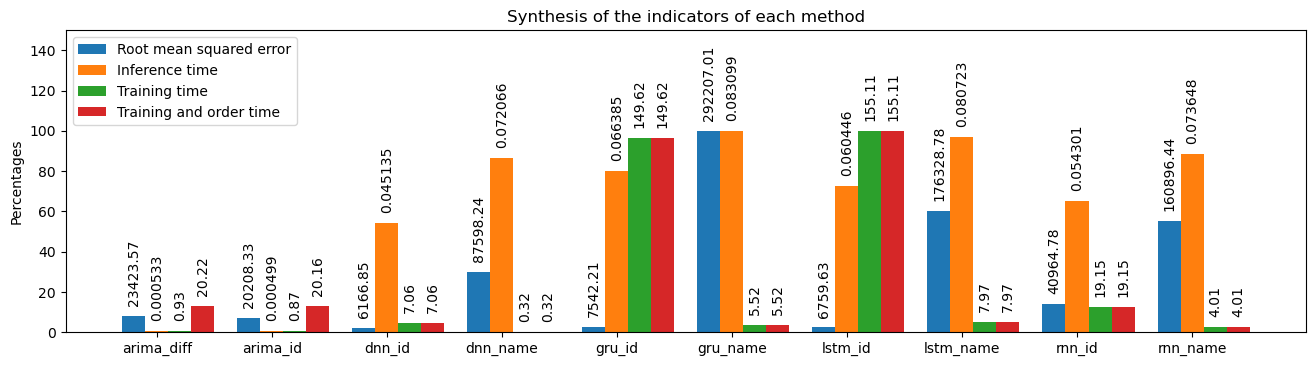

In [7]:
prep = preparation(mean_squared, inference, training, order_training)
histo(prep)

The most important indicator is the accuracy one because even if an algorithm is the fastest, if its prediction are not accurate, it will be useless. So we will display the **RMS** indicator of each time series and for each algorithm.  
First we can see that each method has spikes on the same time series, and secondly we can also see that the scale is not appropriate because this spikes are in big numbers ($10^7$). So we can display the same graph with a logarithm scale. Here we can see that apart from certain exceptions, the **RMS** indicator of each method are more or less under 1000 which means that the algorithms are pretty accurate.

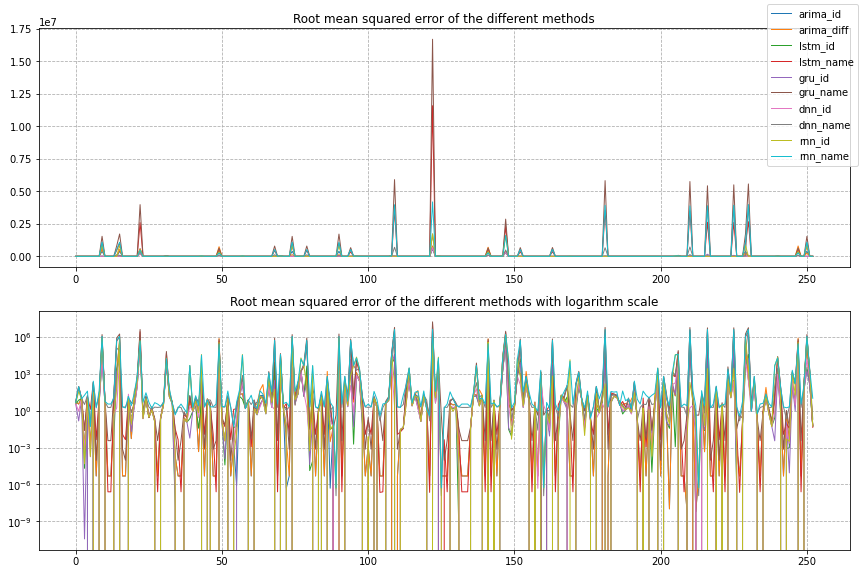

In [8]:
root_mean(dataset, dataname)

We are therefore going to look at these extreme values using boxplots and we notice that our datasets have a lot of outliers. So much so that we don't even see the boxes. So we are going to reshape our data to do not take these outliers into account.

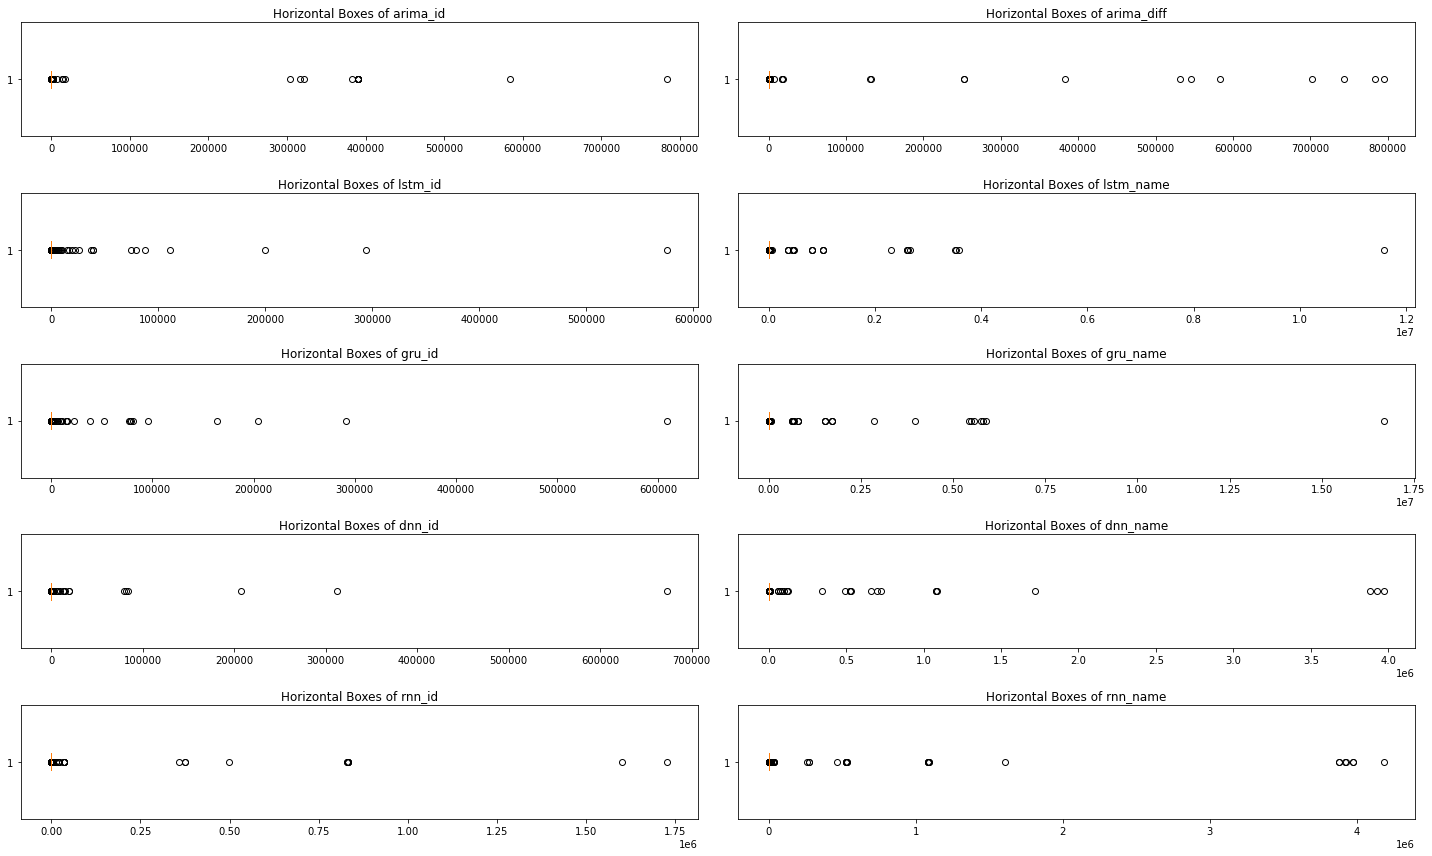

In [9]:
string = 'mean_squared_error'
moustaches(dataset, dataname, string)

## 4) Second analysis: outliers in function of their methods

We are going to follow the same steps but without taking into account the outliers.  
In fact there is two ways to do this, we can delete all the outliers of each methods for all the methods we can delete the outliers of each methods just for the corresponding methods.  
First we will delete the outliers of their correspouding algorithm. (I think that this method is the most significant).  
Here we can see the boxplot so data are more significant, but of course we loose more data using this method, almost 20%.

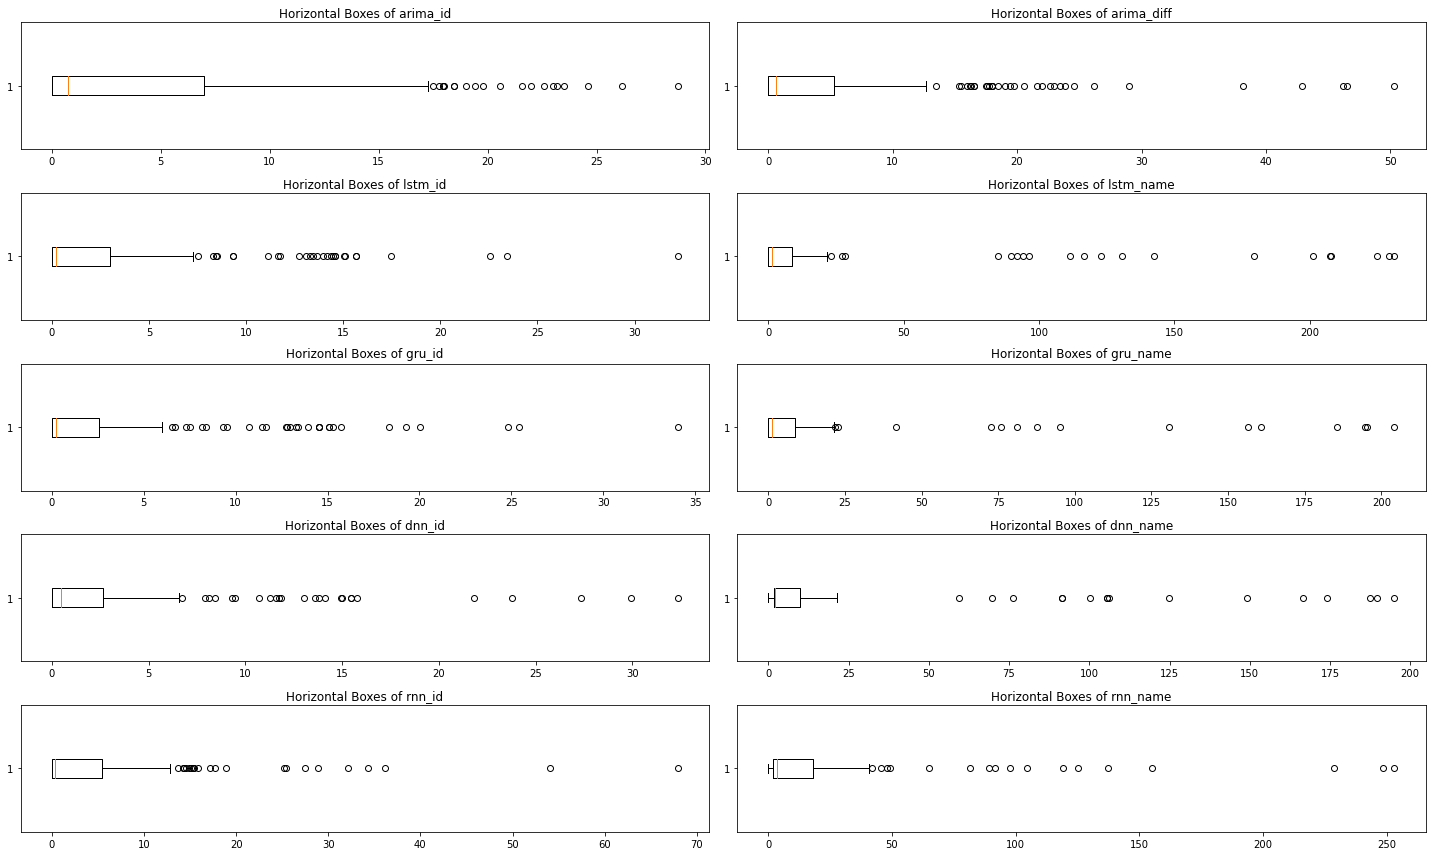

In [10]:
val_aber(dataset, string)
for algo in dataset:
    algo.reset_index(inplace=True)
moustaches(dataset, dataname, string)

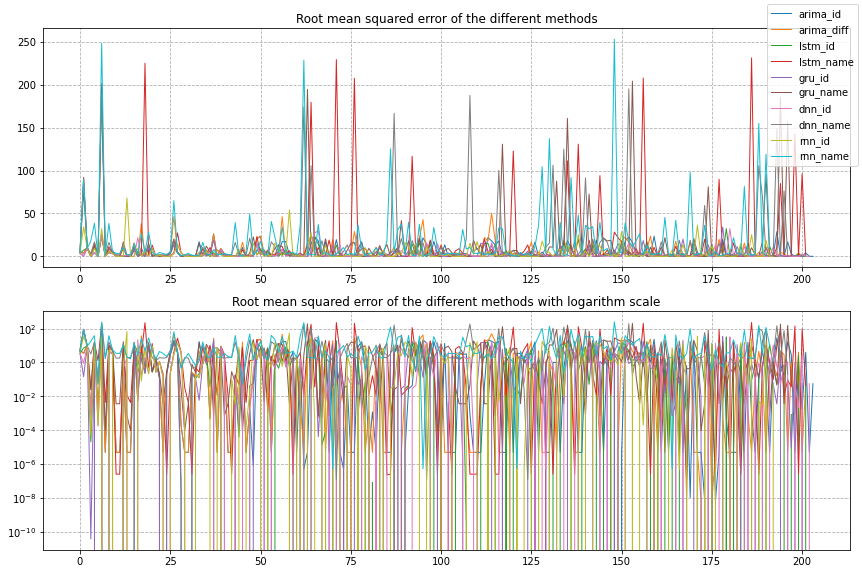

In [11]:
root_mean(dataset, dataname)

In [12]:
mean_squared = synthesis(dataset, dataname, 'mean_squared_error', 2, True)

Mean squared error comparaison :
dnn_id      :        2.75        |        arima_diff  :        5.31
lstm_id     :        2.83        |        gru_name    :       12.43
gru_id      :        2.87        |        dnn_name    :       14.51
rnn_id      :        4.42        |        lstm_name   :       16.34
arima_id    :        4.76        |        rnn_name    :       18.62


In [13]:
inference = synthesis(dataset, dataname, 'inference_time', 6, True)

Inference time comparaison (seconds) :
arima_id    :    0.000491        |        gru_id      :    0.065138
arima_diff  :    0.000521        |        rnn_name    :    0.071324
dnn_id      :    0.044516        |        dnn_name    :    0.073052
rnn_id      :    0.052224        |        lstm_name   :    0.080092
lstm_id     :    0.058212        |        gru_name    :    0.082698


In [14]:
training = synthesis(dataset, dataname, 'training_time', 2, False)

In [15]:
order_training = synthesis(dataset, dataname, 'order_time', 2, True)

Training time and time of order computing for arima comparaison (seconds) :
dnn_name    :        0.42        |        arima_id    :        18.0
rnn_name    :        4.88        |        arima_diff  :       18.24
gru_name    :        6.79        |        rnn_id      :       19.13
dnn_id      :        7.02        |        gru_id      :      148.55
lstm_name   :        9.67        |        lstm_id     :      153.66


We can clearly see that without the outliers all methods are more accurate and faster to train but classement on some indicators have change.

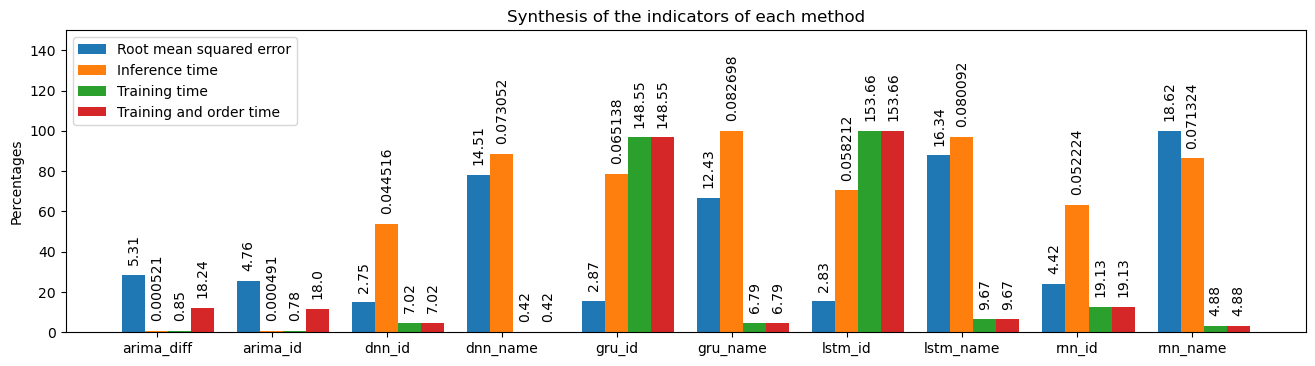

In [16]:
prep = preparation(mean_squared, inference, training, order_training)
histo(prep)

In [17]:
# Comparaison DNN id/name temps d'entrainement/RMS
# comp_idName('DNN', order_training, mean_squared)

In [18]:
# Comparaison DNN id/name temps d'entrainement/RMS
# comp_idName('DNN_30', order_training, mean_squared)

## 5) Third analysis: delete outliers for all methods

We will now reload the data and delete the outliers of all algorithm.
Of course we loose more data using this method, almost 26%.

In [19]:
dataset, dataname = load_dataset(dnn)

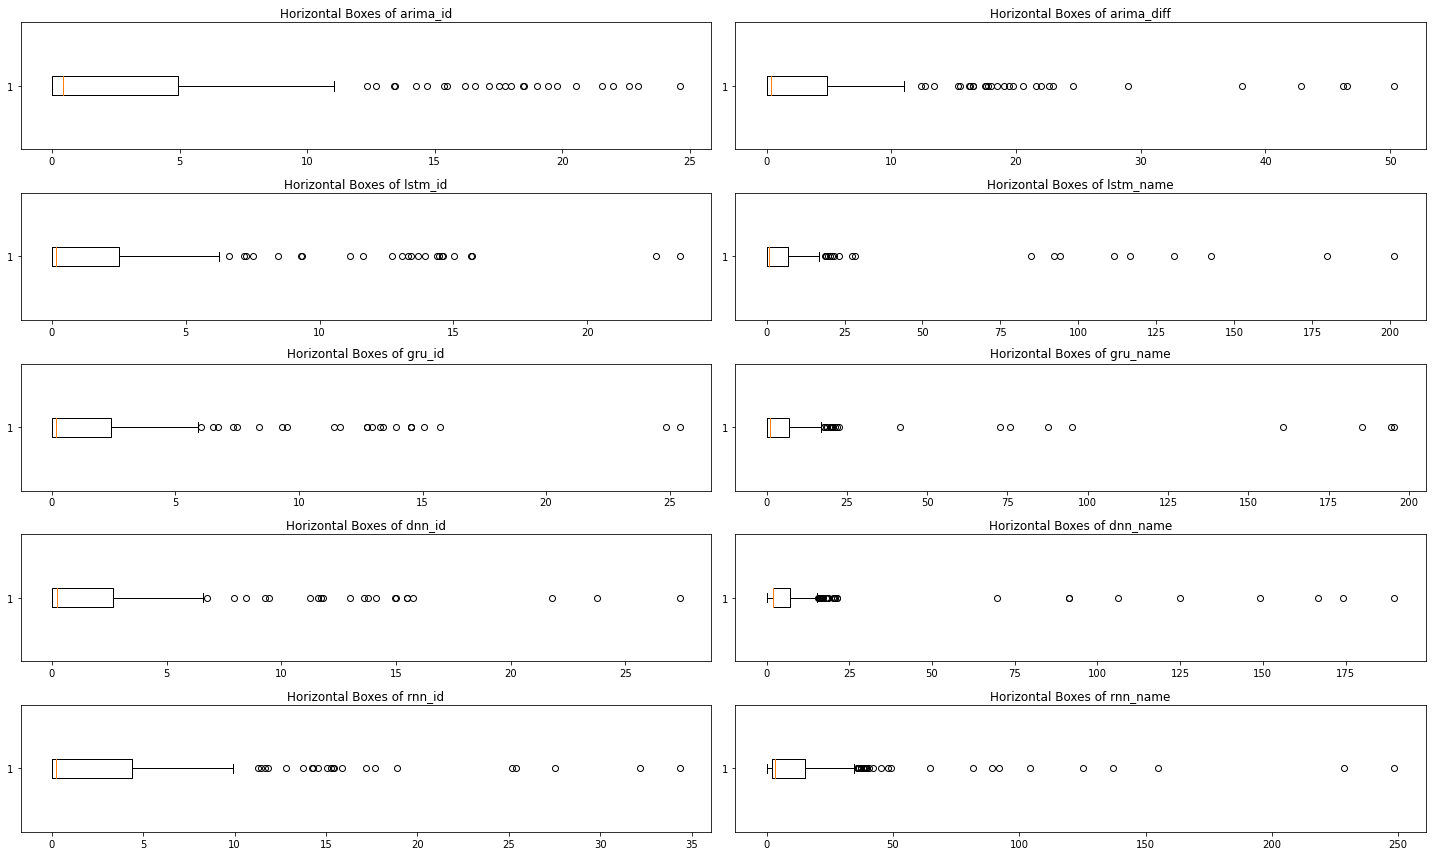

In [20]:
extr = val_extr(dataset, string)
for algo in dataset:
    algo.reset_index(inplace=True)
moustaches(dataset, dataname, string)

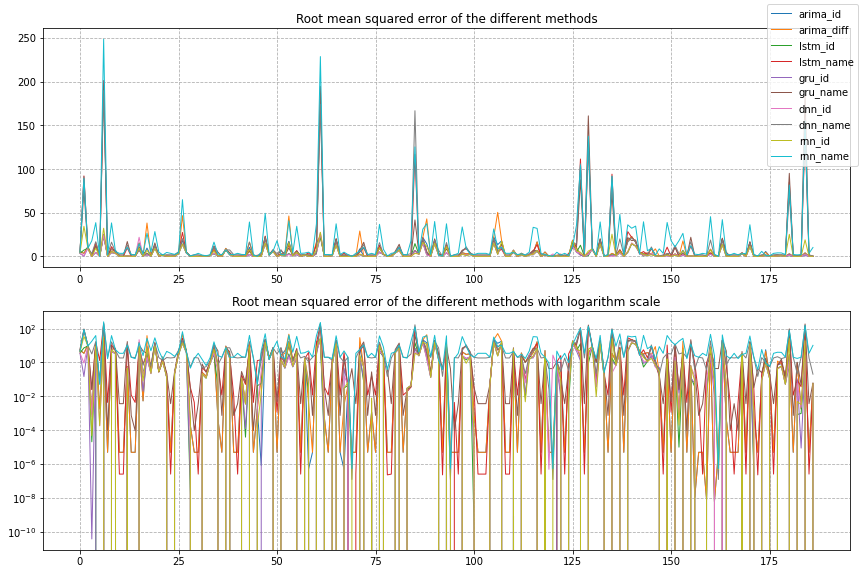

In [21]:
root_mean(dataset, dataname)

In [22]:
mean_squared = synthesis(dataset, dataname, 'mean_squared_error', 2, True)

Mean squared error comparaison :
gru_id      :        2.33        |        arima_diff  :        4.95
lstm_id     :        2.46        |        gru_name    :        9.62
dnn_id      :        2.46        |        lstm_name   :        9.79
rnn_id      :        3.44        |        dnn_name    :       10.72
arima_id    :         3.9        |        rnn_name    :       16.37


In [23]:
inference = synthesis(dataset, dataname, 'inference_time', 6, True)

Inference time comparaison (seconds) :
arima_id    :    0.000489        |        gru_id      :     0.06678
arima_diff  :    0.000518        |        rnn_name    :     0.07065
dnn_id      :    0.044415        |        dnn_name    :    0.073163
rnn_id      :    0.052524        |        lstm_name   :    0.080138
lstm_id     :    0.059405        |        gru_name    :    0.082281


In [24]:
training = synthesis(dataset, dataname, 'training_time', 2, False)

In [25]:
order_training = synthesis(dataset, dataname, 'order_time', 2, True)

Training time and time of order computing for arima comparaison (seconds) :
dnn_name    :        0.36        |        arima_id    :       17.86
rnn_name    :        4.42        |        arima_diff  :       17.94
gru_name    :        6.37        |        rnn_id      :       19.17
dnn_id      :        7.07        |        gru_id      :      149.89
lstm_name   :        9.68        |        lstm_id     :      155.48


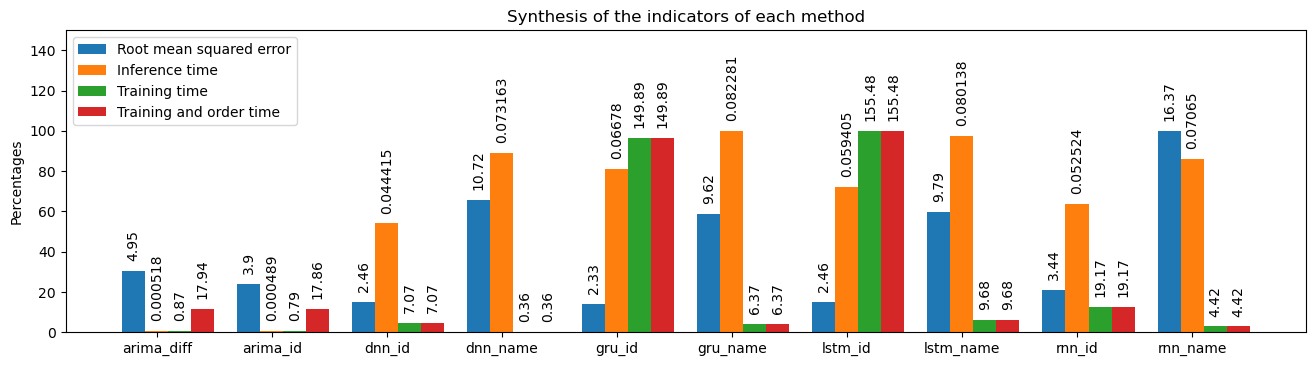

In [26]:
prep = preparation(mean_squared, inference, training, order_training)
histo(prep)

In [27]:
# Comparaison LSTM id/name temps d'entrainement/RMS
# comp_idName('LSTM', order_training, mean_squared)

In [28]:
# Comparaison GRU id/name temps d'entrainement/RMS
# comp_idName('GRU', order_training, mean_squared)

In [29]:
# Comparaison RNN id/name temps d'entrainement/RMS
# comp_idName('RNN', order_training, mean_squared)

In [30]:
# Comparaison DNN id/name temps d'entrainement/RMS
# comp_idName('DNN', order_training, mean_squared)

In [31]:
# Comparaison DNN id/name temps d'entrainement/RMS
# comp_idName('DNN_30', order_training, mean_squared)

## 6) Conclusion: which algorithm to choose ?

We will conclude by using our second analysis, the one where we removed the outliers linked to their method. In my opinion, the results of this analysis are the most representative.  
We can disting 3 algorithms, one for each indicators:
- Training time: dnn_name
- Inference time: arima_id
- Accuracy: dnn_id

The most important indicator is that of precision, but *dnn_name* is one of the least precise algorithms. If we forget about these two algorithms, then the new ones with the lowest training time are *gru_name* and *rnn_name* which are also not precise. Thus we then find *dnn_id* which is also the most precise and (after *ARIMA*) with the lowest inference time.  
If we look at our first analysis, we can note that the results are exactly the same as ones of the second analysis. On another hand, the third scan has different results for the accuracy indicator, it is the *gru_id* algorithm which is the more accurate and in the second place we find *dnn_id*. But as we can see, the training time of  *gru_id* is 21 times longer than the *dnn_id*'s one. In the end, we can also find the same conclusion as the previous analysis.

Now we can ask ourselves a new question, with which analysis window and with how many units is this method the best?

After having tried different combinations between the loock back window and the composition of our neuron network, it turns out that the best arrangement found is the one with a look_back=10 and with 2 hidden layers of 16 neurons each.